In [ ]:
import numpy as np
import os
import scipy.stats as ss
import matplotlib.pyplot as plt
# %matplotlib widget
import datetime
from cedne import utils
import matplotlib
matplotlib.rcParams['font.family'] = 'Arial'
matplotlib.rcParams['svg.fonttype'] = 'none'
from sklearn.preprocessing import StandardScaler, PCA
from scipy.signal import butter, filtfilt, welch

In [2]:
today = str(datetime.datetime.now()).split(' ')[0]
outputDir = "Output/" + today + "/"
if not os.path.exists(outputDir):
    os.makedirs(outputDir)

num_timepoints = 450
conds = ['naive', 'trained']
stimuli = ['OP-PA-OP', 'OP-Buffer-OP', 'Buffer-PA-Buffer', 'Buffer-Buffer-Buffer', 'OP-gacA-OP']
promoters = ['ncs-1', 'inx-4', 'glr-1', 'acr-5', 'inx-4+mbr-1', 'flp-3p+flp-7p+nmr-1p+sro-1p', 'odr-2(2b)+odr-2(18)p']

In [3]:
color_stim = {'OP': '#e4ab24',
              'PA': '#1a9d77',
              'Buffer': '#f9f4d7',
              'gacA': "#c2ffee"}

color_conds = {'naive': '#888666',
               'trained': '#6b3e98'}

In [4]:
def mm_to_inches(fig_dims):
    fig_width_mm, fig_height_mm = fig_dims
    return (fig_width_mm / 25.4, fig_height_mm / 25.4)

single_column = 90
double_column = 180
max_height = 170
font_size_big = 7 #pts
font_size_mid = 6
font_size_small = 5
DPI = 600

In [5]:
data = {}
ecc = {}
empty_worms = {}
for stim in os.listdir('./behavior_data/eccentricity data'):
    if not stim.startswith('.') and not stim.startswith('_'):
        data[stim] = {}
        ecc[stim] = {'naive': [], 'trained': []}
        empty_worms[stim] = {}
        print(stim)
        for j,csvfile in enumerate(os.listdir('./behavior_data/eccentricity data/' + stim)):
            print(csvfile)

            if not csvfile.startswith('.'):
                data[stim][j] = np.loadtxt('./behavior_data/eccentricity data/' + stim + '/' + csvfile, delimiter=',', skiprows=1)
                data[stim][j] = data[stim][j][:, 1:]
                empty_worms[stim][j] = []
                for k in range(data[stim][j].shape[1]):
                    if not all(data[stim][j][:, k] == 0):
                        if k<6:
                            ecc[stim]['naive'].append(data[stim][j][:, k])
                        else:
                            ecc[stim]['trained'].append(data[stim][j][:, k])
                    else:
                        empty_worms[stim][j].append(k)
                data[stim][j] = np.delete(data[stim][j], empty_worms[stim][j], axis=1)

OP-PA
20240504-PA_OP_N2_R2_eccentricity_data.csv
20240530-PA_OP_N2_R2_eccentricity_data.csv
20230906_N2-rep1_eccentricity_data.csv
20240501-PA_OP_N2_R1_eccentricity_data.csv
20240517-PA_OP_N2_R2_eccentricity_data.csv
20230822_N2-rep2_eccentricity_data.csv
20230906_N2-rep3_eccentricity_data.csv
20250728_N2-PA-OP-rep4_eccentricity_data.csv
20250805_N2-PA-OP-rep1_eccentricity_data.csv
20230928_n2-repl3_eccentricity_data.csv
20240501-PA_OP_N2-R3_eccentricity_data.csv
20240513-PA_OP_N2_R1_eccentricity_data.csv
20230913_N2-rep2_eccentricity_data.csv
20250805_N2-PA-OP-rep3_eccentricity_data.csv
20230928_n2-repl1_eccentricity_data.csv
20230822_N2-rep1_eccentricity_data.csv
20240517-PA_OP_N2_R1_eccentricity_data.csv
20230906_N2-rep2_eccentricity_data.csv
20240530-PA_OP_N2_R1_eccentricity_data.csv
20240504-PA_OP_N2_R1_eccentricity_data.csv
20230822_N2-rep3_eccentricity_data.csv
20230928_n2-repl2_eccentricity_data.csv
20230913_N2-rep1_eccentricity_data.csv
20240501-PA_OP_N2-R2_eccentricity_data.c

In [8]:
X = []
cond_arr = []
stim_arr = []
for stim in [
    'OP-PA', 
    'PA-Buffer'
    ]:
    for j in range(len(data[stim])):
        X.append(data[stim][j].T[:,1:].reshape(-1, 600))
        nworms = 6
        for i in range(12):
            cond_arr += [0]*(nworms-len([ew for ew in empty_worms[stim][j] if ew < nworms])) + [1]*(nworms-len([ew for ew in empty_worms[stim][j] if ew >= nworms]))
            stim_arr += [stim]*(12-len(empty_worms[stim][j]))
X = np.concatenate(X)

In [14]:
with open('temporal_components.pkl', 'rb') as f:
    temporal_components = pickle.load(f)

In [ ]:
n_components = 3

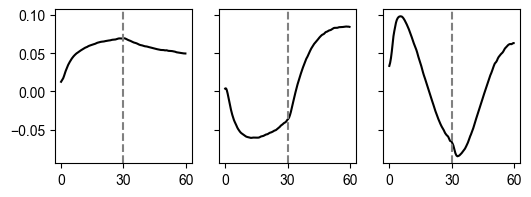

In [16]:
f, ax = plt.subplots(figsize=(2*n_components,2), ncols=n_components, sharex=True, sharey=True)#, sharey=True)
for j in range(n_components):
    ax[j].plot(temporal_components[:,j], color='k')
    ax[j].set_xticks([0,150,300], [0, 30, 60])
    ax[j].axvline(x=150, color='gray', linestyle='--')
plt.show()

In [18]:
# close all figures
plt.close('all')

In [21]:
stimwise_X = {}
miss_cycles = 0
for stim in ecc.keys():
    stimwise_X[stim] = {'naive': [], 'trained': []}
    for j in range(len(ecc[stim]['naive'])):
        stimwise_X[stim]['naive'].append(ecc[stim]['naive'][j].T[miss_cycles*600+1:])
    for j in range(len(ecc[stim]['trained'])):
        stimwise_X[stim]['trained'].append(ecc[stim]['trained'][j].T[miss_cycles*600+1:])
    stimwise_X[stim]['naive'] = np.array(stimwise_X[stim]['naive'])
    stimwise_X[stim]['trained'] = np.array(stimwise_X[stim]['trained'])

#### Correcting order of the stimuli to match calcium imaging.

In [22]:
stim_corrected_dict = {'OP-PA': ['OP', 'PA'], 'PA-Buffer': ['Buffer', 'PA'], 'OP-Buffer': ['Buffer', 'OP'], 'Buffer-buffer': ['Buffer', 'Buffer'], 'OP-gacA': ['OP', 'gacA']}

In [24]:
stim_all = []
for stimulus in stimwise_X:
    for cond in stimwise_X[stimulus]:
        stim_all.append(stimwise_X[stimulus][cond])

stim_all = np.vstack(stim_all)

In [26]:
def cutoff_from_cumpower(X, fs, target=0.9):     # X: worms×time
    f, P = welch(X.mean(0), fs=fs, nperseg=min(1024, X.shape[1]))
    c = np.cumsum(P) / np.sum(P)
    k = np.searchsorted(c, target)
    fc = f[k]
    return float(fc), f, P

In [27]:
## Filter the data
from scipy.signal import butter, filtfilt, welch
filter_window = 11
poly_order = 3
fs = 10.0
power_target = 0.995
stimwise_X_filtered = {}
filt = 'butter'
from scipy.signal import savgol_filter
for stim in stimwise_X:
    stimwise_X_filtered[stim] = {}
    for cond in conds:
        stimwise_X_filtered[stim][cond] = np.zeros_like(stimwise_X[stim][cond])
        for i in range(stimwise_X[stim][cond].shape[0]):
            if filt == 'savgol':
                stimwise_X_filtered[stim][cond][i] = savgol_filter(stimwise_X[stim][cond][i], filter_window, poly_order)
            elif filt == 'butter':
                fc, f, P = cutoff_from_cumpower(stim_all, fs=10.0, target=power_target)
                b,a = butter(N=4, Wn=fc/(fs/2), btype='low')  # 4th-order Butterworth
                stimwise_X_filtered[stim][cond][i] = filtfilt(b, a, stimwise_X[stim][cond][i])  # zero-phase

In [40]:
## Triads of periods instead of diads for eccentricity data. 
X_triads = []
cond_triads = []
stim_arr_triads = []
window_size = 900
window_step = 600
skip_cycles = 3
cycle_length = 600
nworms = 6

for stim in [
    'OP-PA', 
    'PA-Buffer',
    'OP-Buffer',
    'Buffer-buffer',
    'OP-gacA'
    ]:
    for j in range(len(data[stim])):
        by_worm = []
        # for i, start in enumerate(range(0, data[stim][j].shape[0] - window_size + 1, window_step)):
        cycle_start = skip_cycles*cycle_length
        if stim == 'OP-Buffer':
            cycle_start= skip_cycles*cycle_length - 300
        for i, start in enumerate(range(cycle_start, stimwise_X_filtered[stimulus][cond].shape[1] - window_size + 1, cycle_length)):
            # X_triads.append(data[stim][j].T[:, start:start + window_size])
            by_worm.append(data[stim][j].T[:, start:start + window_size])
        worm_median = np.median(by_worm, axis=0)
        
        X_triads.append(worm_median)
        # X_triads+=by_worm
        ncycles = len(by_worm)
        # cond_triads += [0]*(nworms-len([ew for ew in empty_worms[stim][j] if ew < nworms]))*ncycles + [1]*(nworms-len([ew for ew in empty_worms[stim][j] if ew >= nworms]))*ncycles
        # stim_arr_triads += [stim]*(12-len(empty_worms[stim][j]))*ncycles
        cond_triads += [0]*(nworms-len([ew for ew in empty_worms[stim][j] if ew < nworms])) + [1]*(nworms-len([ew for ew in empty_worms[stim][j] if ew >= nworms]))
        stim_arr_triads += [stim]*(12-len(empty_worms[stim][j]))
X_triads = np.concatenate(X_triads)

In [42]:
def normalize_triads(X_tr, baseline_period=(200,300)):
    baseline = X_tr[:,baseline_period[0]:baseline_period[1]]
    baseline_val = np.mean(baseline, axis=1, keepdims=True)
    # baseline_sd = np.std(baseline, axis=1, keepdims=True)
    return (X_tr-baseline_val)/baseline_val

In [43]:
X_triads_norm = normalize_triads(X_triads)#[:,:] 

## Fig 2e

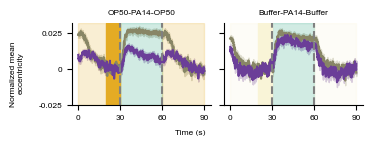

In [46]:
figsize = mm_to_inches((single_column, max_height/5))
f, ax = plt.subplots(figsize=figsize, ncols=2, sharex=True, sharey=True, layout='constrained')
X_triads_norm_op_naive = np.array([X_triads_norm[j] for j in range(len(cond_triads)) if cond_triads[j] == 0 and stim_arr_triads[j] == 'OP-PA'])
X_triads_norm_op_trained = np.array([X_triads_norm[j] for j in range(len(cond_triads)) if cond_triads[j] == 1 and stim_arr_triads[j] == 'OP-PA'])
X_triads_norm_buffer_naive = np.array([X_triads_norm[j] for j in range(len(cond_triads)) if cond_triads[j] == 0 and stim_arr_triads[j] == 'PA-Buffer'])
X_triads_norm_buffer_trained = np.array([X_triads_norm[j] for j in range(len(cond_triads)) if cond_triads[j] == 1 and stim_arr_triads[j] == 'PA-Buffer'])

ax[0].plot(np.mean(X_triads_norm_op_naive, axis=0), color=color_conds['naive'])
ax[0].fill_between(np.arange(X_triads_norm_op_naive.shape[1]), np.mean(X_triads_norm_op_naive, axis=0) - ss.sem(X_triads_norm_op_naive, axis=0), np.mean(X_triads_norm_op_naive, axis=0) + ss.sem(X_triads_norm_op_naive, axis=0), color=color_conds['naive'], alpha=0.3)
ax[0].plot(np.mean(X_triads_norm_op_trained, axis=0), color=color_conds['trained'])
ax[0].fill_between(np.arange(X_triads_norm_op_trained.shape[1]), np.mean(X_triads_norm_op_trained, axis=0) - ss.sem(X_triads_norm_op_trained, axis=0), np.mean(X_triads_norm_op_trained, axis=0) + ss.sem(X_triads_norm_op_trained, axis=0), color=color_conds['trained'], alpha=0.3)

ax[0].set_xticks([0,300,600, 900], [0, 30, 60, 90], fontsize=font_size_mid)
ax[0].axvline(x=300, color='gray', linestyle='--')
ax[0].axvline(x=600, color='gray', linestyle='--')

ax[0].axvspan(xmin=0, xmax=300, color=color_stim[stim_corrected_dict['OP-PA'][0]], alpha=0.2)
ax[0].axvspan(xmin=300, xmax=600, color=color_stim[stim_corrected_dict['OP-PA'][1]], alpha=0.2)
ax[0].axvspan(xmin=600, xmax=900, color=color_stim[stim_corrected_dict['OP-PA'][0]], alpha=0.2)
# highlight baseline period
ax[0].axvspan(xmin=200, xmax=300, color=color_stim[stim_corrected_dict['OP-PA'][0]], alpha=1)

ax[1].plot(np.mean(X_triads_norm_buffer_naive, axis=0), color=color_conds['naive'])
ax[1].fill_between(np.arange(X_triads_norm_buffer_naive.shape[1]), np.mean(X_triads_norm_buffer_naive, axis=0) - ss.sem(X_triads_norm_buffer_naive, axis=0), np.mean(X_triads_norm_buffer_naive, axis=0) + ss.sem(X_triads_norm_buffer_naive, axis=0), color=color_conds['naive'], alpha=0.3)
ax[1].plot(np.mean(X_triads_norm_buffer_trained, axis=0), color=color_conds['trained'])
ax[1].fill_between(np.arange(X_triads_norm_buffer_trained.shape[1]), np.mean(X_triads_norm_buffer_trained, axis=0) - ss.sem(X_triads_norm_buffer_trained, axis=0), np.mean(X_triads_norm_buffer_trained, axis=0) + ss.sem(X_triads_norm_buffer_trained, axis=0), color=color_conds['trained'], alpha=0.3)

ax[1].set_xticks([0,300,600, 900], [0, 30, 60, 90], fontsize=font_size_mid)
ax[1].axvline(x=300, color='gray', linestyle='--')
ax[1].axvline(x=600, color='gray', linestyle='--')

ax[1].axvspan(xmin=0, xmax=300, color=color_stim[stim_corrected_dict['PA-Buffer'][0]], alpha=0.2)
ax[1].axvspan(xmin=300, xmax=600, color=color_stim[stim_corrected_dict['PA-Buffer'][1]], alpha=0.2)
ax[1].axvspan(xmin=600, xmax=900, color=color_stim[stim_corrected_dict['PA-Buffer'][0]], alpha=0.2)
# highlight baseline period
ax[1].axvspan(xmin=200, xmax=300, color=color_stim[stim_corrected_dict['PA-Buffer'][0]], alpha=1)
ax[0].set_yticks([-0.025,0,0.025], [-0.025,0,0.025], fontsize=font_size_mid)
ax[1].set_yticks([-0.025,0,0.025], [-0.025,0,0.025], fontsize=font_size_mid)
utils.simpleaxis(ax)
ax[0].set_title('OP50-PA14-OP50', fontsize=font_size_mid)
ax[1].set_title('Buffer-PA14-Buffer', fontsize=font_size_mid)
f.supylabel('Normalized mean \neccentricity', fontsize=font_size_mid, ha='center')
f.supxlabel('Time (s)', fontsize=font_size_mid)
plt.savefig(outputDir + 'mean_turning_rate_across_conditions_triads_normed.svg', dpi=600, transparent=True)
plt.show()

In [ ]:
for stim1, stim2 in zip([300, 600], [600, 900]):
    print(f"Stimulus period {stim1}-{stim2}")
    print(f"OP-PA ", ss.ttest_ind(np.mean(X_triads_norm_op_naive[:,stim1:stim2], axis=1), np.mean(X_triads_norm_op_trained[:,stim1:stim2], axis=1)))
    print(f"Buffer-PA: ", ss.ttest_ind(np.mean(X_triads_norm_buffer_naive[:,stim1:stim2], axis=1), np.mean(X_triads_norm_buffer_trained[:,stim1:stim2], axis=1)))
    # print(f"OP-Buffer: ", ss.ttest_ind(np.mean(X_triads_opbuffer_naive[:,stim1:stim2], axis=1), np.mean(X_triads_opbuffer_trained[:,stim1:stim2], axis=1)))
    # print(f"Buffer-Buffer: ", ss.ttest_ind(np.mean(X_triads_bufferbuffer_naive[:,stim1:stim2], axis=1), np.mean(X_triads_bufferbuffer_trained[:,stim1:stim2], axis=1)))
    # print(f"OP-gacA: ", ss.ttest_ind(np.mean(X_triads_opgaca_naive[:,stim1:stim2], axis=1), np.mean(X_triads_opgaca_trained[:,stim1:stim2], axis=1)))e

NameError: name 'X_triads_op_naive' is not defined

In [63]:
def project_to_components(X, temp_comps):
    return np.dot(X, temp_comps.T)

In [ ]:
stimulus_list = ['OP-PA', 'PA-Buffer']#, 'OP-Buffer', 'Buffer-buffer']
skip_cycles = 3
cycle_length = 600
triad_length = 900
step_size = 300
n_components = 3

stim_cycles = []
stim_cond = []
worm_inds = []
for stimulus in stimulus_list:
    for cond in stimwise_X_filtered[stimulus]:
        print(f"{stimulus} {cond}: {stimwise_X_filtered[stimulus][cond].shape}")
        for i, start in enumerate(range(skip_cycles*cycle_length, stimwise_X_filtered[stimulus][cond].shape[1] - triad_length + 1, cycle_length)):
            stim_cycles.append(stimwise_X_filtered[stimulus][cond][:, start:start+triad_length])
            if stimulus == 'OP-PA':
                stim_lab = 'OP-PA'
            elif stimulus == 'PA-Buffer':
                stim_lab = 'Buffer-PA'
            stim_cond += [(stim_lab, cond)]*stimwise_X_filtered[stimulus][cond].shape[0]
            worm_inds += [f'{x+1}' for x in range(stimwise_X_filtered[stimulus][cond].shape[0])]
stim_cycles = np.vstack(stim_cycles)
worm_inds = np.vstack(worm_inds)
stim_cond = np.array(stim_cond)
normed_smoothed_triads = normalize_triads(stim_cycles)#[:, 300:]  # only analyze response to 2nd stimulus
stim_arr_triads = list(zip(*stim_cond))[0]
cond_triads = [0 if c[1] == 'naive' else 1 for c in stim_cond]

OP-PA naive: (180, 7200)
OP-PA trained: (177, 7200)
PA-Buffer naive: (138, 7200)
PA-Buffer trained: (136, 7200)


  after skipping 3 cycles: (5048, 900)
  explained variance ratios: [0.33622926 0.3974104  0.43696655]


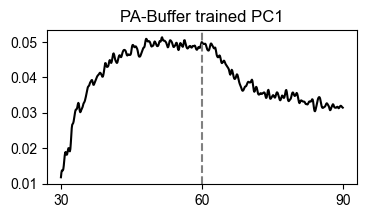

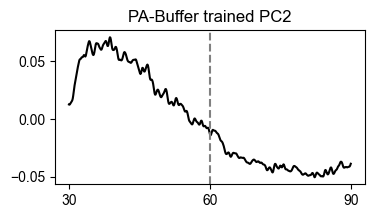

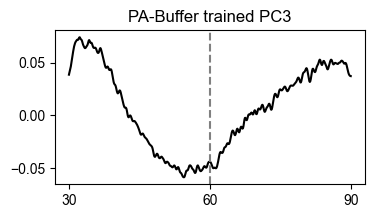

In [74]:
normed_smoothed_triads = normed_smoothed_triads[:, 300:]  # only analyze response to 2nd stimulus onward
sc = StandardScaler(with_mean=False)
normed_smoothed_triads = sc.fit_transform(normed_smoothed_triads)
pca = PCA(n_components=n_components)
pca.fit(normed_smoothed_triads)
print(f"  after skipping {skip_cycles} cycles: {stim_cycles.shape}")
print(f"  explained variance ratios: {np.cumsum(pca.explained_variance_ratio_)}")
for i in range(n_components):
    f, ax = plt.subplots(figsize=(4,2))
    ax.plot(pca.components_[i], color='k')
    ax.set_title(f"{stimulus} {cond} PC{i+1}")
    ax.set_xticks([0,300,600], [30, 60, 90])
    ax.axvline(x=300, color='gray', linestyle='--')
    plt.show()

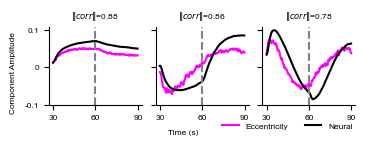

In [87]:
def mm_to_inches(fig_dims):
    fig_width_mm, fig_height_mm = fig_dims
    return (fig_width_mm / 25.4, fig_height_mm / 25.4)

n_components = 3
single_column = 90
double_column = 180
max_height = 170
figsize = mm_to_inches((double_column/2, max_height/5))
f, ax = plt.subplots(figsize=figsize, ncols=n_components, sharex=True, sharey=True, layout='constrained')
for j in range(n_components):
    if j in [0,2,3]:
        sign = 1
    else:
        sign = -1
    if j == 0:
        l1 = ax[j].plot(range(pca.components_.shape[1]), sign*pca.components_[j], color='magenta', label='Behav')
        l2 = ax[j].plot(np.arange(temporal_components.shape[0])*2, temporal_components[:,j], color='k', label='Neural')
    else:
        ax[j].plot(range(pca.components_.shape[1]), sign*pca.components_[j], color='magenta', label='Behav')
        ax[j].plot(np.arange(temporal_components.shape[0])*2, temporal_components[:,j], color='k', label='Neural')
    ax[j].axvline(x=300, color='gray', linestyle='--')
    ax[j].set_xticks([0,300,600], [30, 60, 90], fontsize=font_size_mid)
    ax[j].set_yticks([-0.1, 0, 0.1], [-0.1, 0, 0.1], fontsize=font_size_mid)
    utils.simpleaxis(ax[j])
    ax[j].set_title(f'$\|corr\|$' + f'={abs(np.corrcoef(pca.components_[j,::2], temporal_components[:,j])[0,1]):.2f}', fontsize=font_size_mid)
    ax[j].tick_params(axis='y', labelsize=font_size_mid)

f.legend([l1[0], l2[0]], ['Eccentricity', 'Neural'], frameon=False, ncols=2, loc='upper right', bbox_to_anchor=(1., 0.18), fontsize=font_size_mid)
f.supxlabel('Time (s)', fontsize=font_size_mid)
f.supylabel('Component Amplitude', fontsize=font_size_mid)
plt.savefig(f"{outputDir}/triad_pca_components_vs_temporal_all.svg", dpi=DPI, transparent=True)
plt.show()

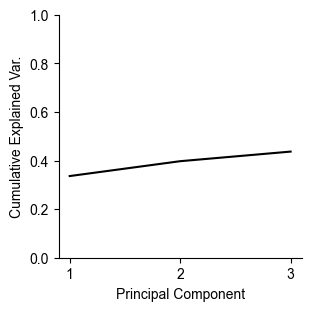

In [78]:
f, ax = plt.subplots(figsize=(3,3), layout='constrained')
ax.plot(np.cumsum(pca.explained_variance_ratio_), color='k')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Cumulative Explained Var.')
ax.set_xticks(np.arange(n_components), np.arange(1, n_components+1))
ax.set_ylim((0,1))
utils.simpleaxis(ax)
plt.show()

In [79]:
np.cumsum(pca.explained_variance_ratio_)

array([0.33622926, 0.3974104 , 0.43696655])